In [78]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [91]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
]

In [80]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])

In [81]:
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(354192, 50) (354192,) (39421, 50) (39421,)


In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [107]:
import imp
imp.reload(models)
model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    #('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
    ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
]

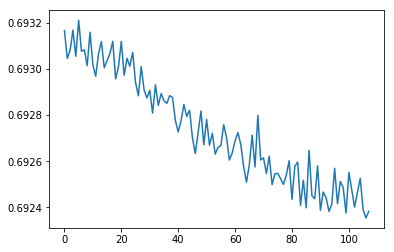

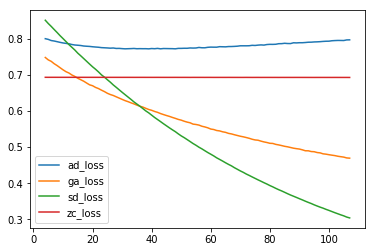

In [94]:
with open(model_list[-1][1]().history_path,'r') as f:
    history=yaml.load(f.read())
history = pd.DataFrame(history)
plt.figure(0)
history.val_loss.plot()
plt.figure(1)
history.drop(columns=['epoch','val_loss']).iloc[4:].plot()

In [95]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [96]:
val_inds.shape

(46362,)

In [108]:
def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = []
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l})
        ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(393613, 1)
trainpath aec cons:0.6667 logloss:0.6927
trainpath aecgan cons:0.6750 logloss:0.6927
trainpath disentangle cons:0.7167 logloss:0.6922
trainpath disentanglegan cons:0.7000 logloss:0.6923
trainpath ganmore cons:0.6750 logloss:0.6926
trainpath xg cons:1.0000 logloss:0.6904
(243686, 1)
testpath aec cons:0.8333 logloss:0.6927
testpath aecgan cons:0.7500 logloss:0.6927
testpath disentangle cons:0.5833 logloss:0.6925
testpath disentanglegan cons:0.6667 logloss:0.6926
testpath ganmore cons:0.8333 logloss:0.6923
testpath xg cons:0.7500 logloss:0.6930


In [98]:
# logloss aecgan 0.693058273797
# logloss aec 0.692759657592
# logloss xg 0.693008686052
# logloss aecganxg 0.692780967413

In [104]:
dn=np.sum(ll_list[0]['disentangle'].log_loss < -np.log(0.5))
nu=ll_list[0]['disentangle'].log_loss.shape[0]
print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
dn=np.sum(ll_list[1]['disentangle'].log_loss < -np.log(0.5))
nu=ll_list[1]['disentangle'].log_loss.shape[0]
print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
print('--')
dn=np.sum(ll_list[0]['disentanglegan'].log_loss < -np.log(0.5))
nu=ll_list[0]['disentanglegan'].log_loss.shape[0]
print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
dn=np.sum(ll_list[1]['disentanglegan'].log_loss < -np.log(0.5))
nu=ll_list[1]['disentanglegan'].log_loss.shape[0]
print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))


0.7167 86 120
0.5833 7 12
--
0.7000 84 120
0.6667 8 12


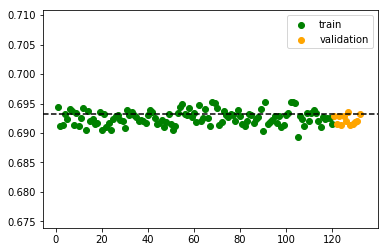

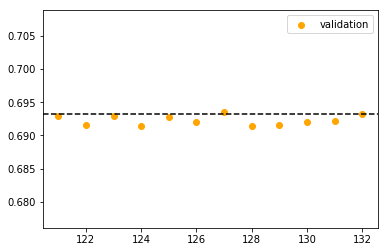

In [112]:
mn = 'ganmore'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

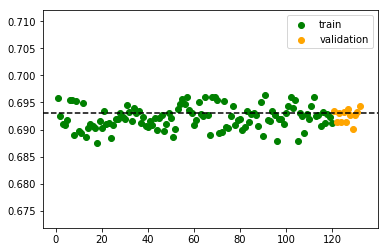

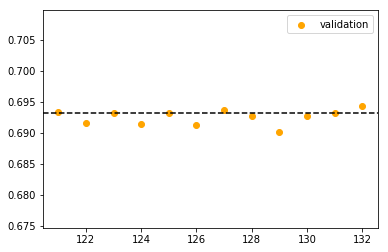

In [106]:
plt.figure(0)
plt.scatter(ll_list[0]['disentangle'].eras,ll_list[0]['disentangle'].log_loss,label='train',color='green')
plt.scatter(ll_list[1]['disentangle'].eras,ll_list[1]['disentangle'].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1]['disentangle'].eras,ll_list[1]['disentangle'].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import imp
imp.reload(opt)

In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))